In [1]:
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
plt.style.use(['science','notebook'])
# plt.style.use(['science'])

# Phase Field Crystal equation

The free-energy is defined as 

$$ F[\eta(\boldsymbol{r})] = \int_V \text{d}{\boldsymbol{r}} \left[ \frac{1}{2} \eta \left(1+\nabla^2\right)^2 \eta + \frac{1}{4} \eta^2(2r+\eta^2) \right] $$


$$ \frac{\partial \eta}{\partial t} = M \nabla^2 \left[ \nabla^4 \eta + 2\nabla^2 \eta  + (1+r) \eta + \eta^3 \right]$$


The implemented time integration methods are:
- `'IMEX'`: implicit-explicit Euler method;
- `'IF'`: Integrating Factor method
- `'ETD'`: Exponential Time Differencing

In [2]:
# Choosing the time integration method
method = 'ETD'

In [6]:
import numpy as np
from scipy.fft import fft2, ifft2
# PFC model constants
r = -0.25
M = 1.0 # mobility
# Size of the system
N = 2**8 # 2**8 = 256
L = 16*np.pi
x = np.linspace(0,L,N)
dx = x[1]-x[0]
# The time step definition
h = 0.01
T = 1500
Nsteps = int(T/h)
dframes = 1.0 # time step to output
Nframes = int(T/dframes) #frames to the output
nframes = Nsteps//Nframes
# The array of outputs
n = np.empty((Nframes,N,N), dtype=np.float32)
# The Fourier variables
n_k = np.empty((N,N), dtype=np.complex64)
kx = np.fft.fftfreq(N, d=dx)*2*np.pi
k = np.array(np.meshgrid(kx , kx ,indexing ='ij'), dtype=np.float32)
k2 = np.sum(k*k,axis=0, dtype=np.float32)
kmax_dealias = kx.max()*2.0/3.0 # The Nyquist mode
# Dealising matrix
dealias = np.array((np.abs(k[0]) < kmax_dealias )*(np.abs(k[1]) < kmax_dealias ),dtype =bool)
# The linear terms of PDE
Loperator_k = -M*k2*(k2**2-2*k2+1+r)
# The non-linear terms of PDE (with dealising)
def Noperator_func(n):
    return -(k2*M*fft2(n**3))
# Defining the time marching operators arrays
# can be calculated once
if method == 'IMEX':
    Tlinear_k = 1.0/(1.0-h*Loperator_k) 
    Tnon_k = dealias*h/(1.0-h*Loperator_k) 
elif method == 'IF':
    Tlinear_k = np.exp(h*Loperator_k) 
    Tnon_k = dealias*h*Tlinear_k
elif method == 'ETD':
    Tlinear_k = np.exp(h*Loperator_k) 
    def myexp(x):
        if x == 1: return 1.0
        else: return (x-1.0)/np.log(x)
    vmyexp = np.vectorize(myexp) # vectorize myexp (could be jitted)
    Tnon_k = dealias*h*vmyexp(Tlinear_k)
else: print('ERROR: Undefined Integrator')
# Initial condition
rng = np.random.default_rng(12345)
n0 = -0.285
noise = 0.02*np.abs(n0)
n[0] = n0 +noise*rng.standard_normal(n[0].shape)
Noperator_k = n_k.copy() # auxiliary array
nn = n[0].copy() # auxiliary array
n_k[:] = fft2(n[0]) # FT initial condition
# time evolution loop
for i in range(1,Nsteps):
    # calculate the nonlinear operator (with dealising)
    Noperator_k[:] = Noperator_func(nn)
    # updating in time
    n_k[:] = n_k*Tlinear_k + Noperator_k*Tnon_k 
    # IFT to next step
    nn[:] = ifft2(n_k).real 
    # test to output
    if (i % nframes) == 0: n[i//nframes] = nn

/tmp/ipykernel_376749/3005389790.py:45: RuntimeWarning: divide by zero encountered in log
  else: return (x-1.0)/np.log(x)


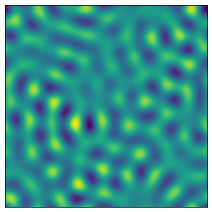

In [4]:
j=10
plt.imshow(n[j],cmap='viridis')
plt.xticks([])
plt.yticks([])
# plt.savefig('../../figuras/pfc2d-profile-eta0='+str(n0)+'-t='+str(j*dframes)+'-'+method+'.pdf')

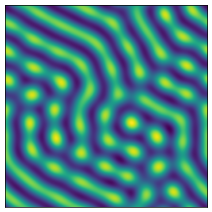

In [23]:
j=100
plt.imshow(n[j],cmap='viridis')
plt.xticks([])
plt.yticks([])
# plt.savefig('../../figuras/pfc2d-profile-eta0='+str(n0)+'-t='+str(j*dframes)+'-'+method+'.pdf')

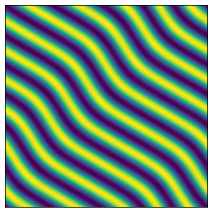

In [24]:
j=500
plt.imshow(n[j],cmap='viridis')
plt.xticks([])
plt.yticks([])
# plt.savefig('../../figuras/pfc2d-profile-eta0='+str(n0)+'-t='+str(j*dframes)+'-'+method+'.pdf')

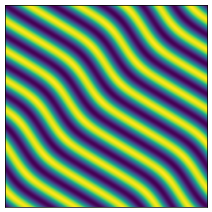

In [25]:
j=1000
plt.imshow(n[j],cmap='viridis')
plt.xticks([])
plt.yticks([])
# plt.savefig('../../figuras/pfc2d-profile-eta0='+str(n0)+'-t='+str(j*dframes)+'-'+method+'.pdf')

In [31]:
# # Saving the data of the profiles
# np.save('../../results/pfc2d-eta0='+str(n0)+'-profile-first.npy',n[10])
# np.save('../../results/pfc2d-eta0='+str(n0)+'-profile-second.npy',n[100])
# np.save('../../results/pfc2d-eta0='+str(n0)+'-profile-third.npy',n[500])
# np.save('../../results/pfc2d-eta0='+str(n0)+'-profile-last.npy',n[-1])

# Testing Convergence

In [46]:
print(n[0].sum()*dx**2/L**2,n[-1].sum()*dx**2/L**2)

-0.0856594669117647 -0.08565945940263359


In [4]:
error = np.zeros(Nframes)
t = np.linspace(0.0,Nsteps*h,Nframes)
for i in range(Nframes):
    error[i] = np.abs(np.sum(n[0])-np.sum(n[i]))/np.abs(np.sum(n[0]))

In [48]:
error.min()

0.0

(1e-16, 0.001)

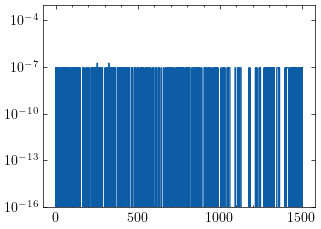

In [49]:
plt.yscale('log')
plt.plot(t[1:],error[1:])
plt.ylim(1e-16,1e-3)

In [50]:
# np.save('../../results/conservation-pfc2d-eta0='+str(n0)+'-'+method+'.npy',[t,error])

## Free-energy calculation

In [51]:
F = np.zeros(Nframes)
t = np.linspace(0.0,Nsteps*h,Nframes)
lapn = np.empty((N,N), dtype=np.float32)
laplapn = np.empty((N,N), dtype=np.float32)
for i in range(t.size):
    n_k[:] = fft2(n[i])
    lapn[:] = ifft2(-k2*n_k).real
    laplapn[:] = ifft2(k2**2*n_k).real
    F[i] = np.sum(n[i]*(lapn+0.5*laplapn)+0.5*(1+r)*n[i]**2 + 0.25*n[i]**4)*dx**2

[]

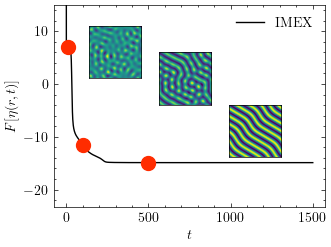

In [52]:
fig, ax1 = plt.subplots()
ax1.plot(t,F,'k',label=method)
ax1.scatter(t[10],F[10],s=100,color='C3',zorder=5)
ax1.scatter(t[100],F[100],s=100,color='C3',zorder=5)
ax1.scatter(t[500],F[500],s=100,color='C3',zorder=5)
ax1.legend(loc='best')
ax1.set_ylim(None,15)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$F[\eta(r,t)]$')

ax2 = fig.add_axes([0.6, 0.3, 0.2, 0.2])
ax2.imshow(n[500],cmap='viridis')
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_axes([0.4, 0.5, 0.2, 0.2])
ax3.imshow(n[100],cmap='viridis')
ax3.set_xticks([])
ax3.set_yticks([])

ax4 = fig.add_axes([0.2, 0.6, 0.2, 0.2])
ax4.imshow(n[10],cmap='viridis')
ax4.set_xticks([])
ax4.set_yticks([])

In [53]:
# np.save('../../results/free-energy-pfc2d-eta0='+str(n0)+'-'+method+'.npy',[t,F])

## Generate video MP4

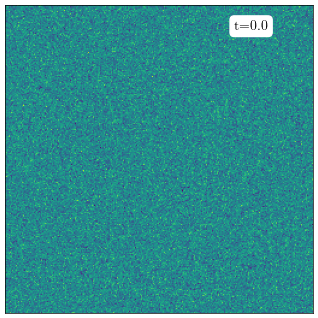

In [7]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

fig, ax = plt.subplots(1,1,figsize=(4,4))

def animate(i):
    ax.clear()
    ax.imshow(n[i],cmap='viridis')
    ax.text(190,20,'t={:.1f}'.format(t[i]),
            bbox=dict(boxstyle="round",ec='white',fc='white'))
    ax.set_xticks([])
    ax.set_yticks([])

    return fig,


ani = animation.FuncAnimation(fig, animate, frames= Nframes,
                               interval = 50)
writervideo = animation.FFMpegWriter(fps=Nframes//10) 
ani.save('pfc2d-eta0='+str(n0)+'.mp4',writer=writervideo,dpi=200)